<a href="https://colab.research.google.com/github/diro5t/deep_quadric_learning/blob/main/TorchQuadMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(C) Dirk Roeckmann 2023

Simple PyTorch MNIST ~50K parameter model classifier with quadric layers: 784-32-10, batch size of 128 and 20 epochs. Accuracy is in the ~97% range.

NOTE: The goal is NOT to find the minimum model or a certain target accuracy, but to compare it with a ~100K linear model which achieves comparable accuracy after the same number of epochs (see TorchLinMNIST.ipynb).

The quadric model is about half the size as the linear model.

More about quadric models here:

https://github.com/diro5t/deep_quadric_learning

This paradigm is based on my research here:

https://scholar.google.com/citations?hl=en&user=hamuGh4AAAAJ

In [342]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim, Tensor
from torch.nn.parameter import Parameter, UninitializedParameter

import numpy as np
import matplotlib.pyplot as plt
import math

In [343]:
transf = transforms.Compose([transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,)),])

In [344]:
batch_size = 128

train_set = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transf)
test_set = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transf)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [345]:
img_iter = iter(train_loader)
images, labels = next(img_iter)

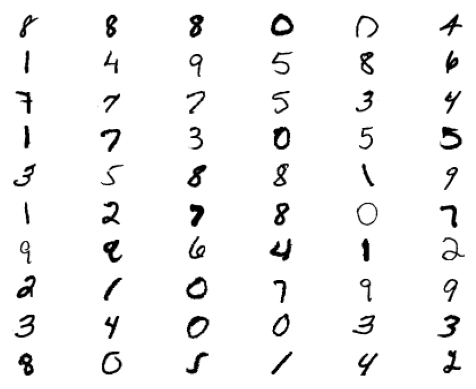

In [346]:
figure = plt.figure()
img_num = 60
for index in range(1, img_num + 1):
    plt.subplot(10, 6, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [347]:
# Custom Quadric PyTorch Layer
class Quadric(nn.Module):
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    qweight: Tensor
    lweight: Tensor

    def __init__(self, in_features: int, out_features: int, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        # quadratic weights
        self.qweight = Parameter(torch.empty((out_features, in_features), **factory_kwargs))
        # linear weights
        self.lweight = Parameter(torch.empty((out_features, in_features), **factory_kwargs))
        # bias
        if bias:
            self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        nn.init.kaiming_uniform_(self.qweight, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.lweight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in_q, _ = nn.init._calculate_fan_in_and_fan_out(self.qweight)
            fan_in_l, _ = nn.init._calculate_fan_in_and_fan_out(self.lweight)
            bound = 1 / math.sqrt(fan_in_l) if fan_in_l > 0 else 0
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, input: Tensor) -> Tensor:
        input_sqr = torch.mul(input, input)
        qi = nn.functional.linear(input, self.qweight, None)
        wib = nn.functional.linear(input, self.lweight, self.bias)
        return torch.add(qi, wib)

    def extra_repr(self) -> str:
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )

In [348]:
model = nn.Sequential(Quadric(784, 32),
                      nn.ReLU(),
                      Quadric(32, 10),
                      nn.LogSoftmax(dim=1))

In [349]:
# total number of model parameters
sum(p.numel() for p in model.parameters())

50858

In [350]:
loss_fn = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
epochs = 20
for e in range(epochs):
    train_loss = 0
    for images, labels in train_loader:
        images = images.view(images.shape[0], -1)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, train_loss/len(train_loader)))

Epoch 0 - Training loss: 0.5333011649183627
Epoch 1 - Training loss: 0.3103450539269681
Epoch 2 - Training loss: 0.27544898134686036
Epoch 3 - Training loss: 0.2448847214899846
Epoch 4 - Training loss: 0.21910274791310846
Epoch 5 - Training loss: 0.19743072092215389
Epoch 6 - Training loss: 0.1801976100293431
Epoch 7 - Training loss: 0.17198046300806472
Epoch 8 - Training loss: 0.1591078070864113
Epoch 9 - Training loss: 0.14980697551611136
Epoch 10 - Training loss: 0.14364047407277866
Epoch 11 - Training loss: 0.13684123403418547
Epoch 12 - Training loss: 0.13212000326847217
Epoch 13 - Training loss: 0.12555377532853118
Epoch 14 - Training loss: 0.12094008146540951
Epoch 15 - Training loss: 0.11783964053066427
Epoch 16 - Training loss: 0.11268102550811605
Epoch 17 - Training loss: 0.10887845201707726
Epoch 18 - Training loss: 0.10548437372850838
Epoch 19 - Training loss: 0.10256016643237331


In [351]:
corrects, all = 0, 0
for images,labels in train_loader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.inference_mode():
        logps = model(img)
    ps = torch.exp(logps)
    prob = list(ps.numpy()[0])
    inf_label = prob.index(max(prob))
    true_label = labels.numpy()[i]
    if(true_label == inf_label):
      corrects += 1
    all += 1

print("Number of trained images=", all)
print("\nModel Training Accuracy =", (corrects / all))

Number of trained images= 60000

Model Training Accuracy = 0.9710333333333333


In [352]:
corrects, all = 0, 0
for images,labels in test_loader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.inference_mode():
        logps = model(img)
    ps = torch.exp(logps)
    prob = list(ps.numpy()[0])
    inf_label = prob.index(max(prob))
    true_label = labels.numpy()[i]
    if(true_label == inf_label):
      corrects += 1
    all += 1

print("Number of tested images=", all)
print("\nModel Test Accuracy =", (corrects / all))

Number of tested images= 10000

Model Test Accuracy = 0.9636
